<a href="https://colab.research.google.com/github/tasleema17/Assignment3-LLM/blob/main/ASSIGNMENT3_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Environment Setup
!pip install transformers datasets

In [10]:
import torch
from transformers import BertTokenizer, BertForTokenClassification, Trainer, TrainingArguments
from datasets import load_dataset, load_metric

In [11]:
#Dataset Selection and Preparation
# Load the CoNLL-2003 dataset
dataset = load_dataset("conll2003", trust_remote_code=True)

In [12]:
print(dataset["train"].features)

{'id': Value(dtype='string', id=None), 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'pos_tags': Sequence(feature=ClassLabel(names=['"', "''", '#', '$', '(', ')', ',', '.', ':', '``', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'NN|SYM', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB'], id=None), length=-1, id=None), 'chunk_tags': Sequence(feature=ClassLabel(names=['O', 'B-ADJP', 'I-ADJP', 'B-ADVP', 'I-ADVP', 'B-CONJP', 'I-CONJP', 'B-INTJ', 'I-INTJ', 'B-LST', 'I-LST', 'B-NP', 'I-NP', 'B-PP', 'I-PP', 'B-PRT', 'I-PRT', 'B-SBAR', 'I-SBAR', 'B-UCP', 'I-UCP', 'B-VP', 'I-VP'], id=None), length=-1, id=None), 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)}


In [13]:
from datasets import load_dataset

# Load the full dataset
dataset = load_dataset("conll2003", split='train')

# Create a smaller subset (e.g., first 1000 examples)
small_dataset = dataset.select(range(1000))

# If you want to split this subset into training and validation
train_small = small_dataset.train_test_split(test_size=0.2)['train']
valid_small = small_dataset.train_test_split(test_size=0.2)['test']

print(f"Training subset size: {len(train_small)} examples")
print(f"Validation subset size: {len(valid_small)} examples")


Training subset size: 800 examples
Validation subset size: 200 examples


In [14]:
from transformers import BertTokenizerFast, BertForTokenClassification, TrainingArguments, Trainer

# Load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

#Preprocessing
label_col = "ner_tags"  # Use the correct column name for NER labels

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    for i, label in enumerate(examples[label_col]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Apply the function to the dataset
tokenized_datasets = small_dataset.map(tokenize_and_align_labels, batched=True)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [15]:
from transformers import BertTokenizerFast, BertForTokenClassification, TrainingArguments, Trainer

# Load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

# Define the function to tokenize and align labels
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        max_length=128,
        padding='max_length',  # Ensure padding to max length
        is_split_into_words=True
    )

    labels = []
    for i, label in enumerate(examples['ner_tags']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)  # Padding for subword tokens

            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs



In [16]:
# Tokenize the training and validation datasets
train_tokenized = train_small.map(tokenize_and_align_labels, batched=True)
valid_tokenized = valid_small.map(tokenize_and_align_labels, batched=True)

# Define label list using the tokenized training dataset
label_list = train_tokenized.features["ner_tags"].feature.names
num_labels = len(label_list)




Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [17]:
# Load the model with the correct number of labels
model = BertForTokenClassification.from_pretrained("bert-base-cased", num_labels=num_labels)


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_steps=10,
    save_steps=100,
    save_total_limit=2,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Define the Trainer using the correctly tokenized datasets
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,  # Use tokenized train dataset
    eval_dataset=valid_tokenized,   # Use tokenized validation dataset
    tokenizer=tokenizer,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [19]:
# Start training
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.240900,0.195222
2,0.141200,0.100446
3,0.067700,0.081160


TrainOutput(global_step=300, training_loss=0.26865463962157565, metrics={'train_runtime': 3399.3082, 'train_samples_per_second': 0.706, 'train_steps_per_second': 0.088, 'total_flos': 156787975987200.0, 'train_loss': 0.26865463962157565, 'epoch': 3.0})

In [20]:
# Evaluate the model
trainer.evaluate()

# Save the model
trainer.save_model("./fine-tuned-bert")

In [21]:
results = trainer.evaluate()
print(f"Evaluation results: {results}")

Evaluation results: {'eval_loss': 0.08115951716899872, 'eval_runtime': 83.511, 'eval_samples_per_second': 2.395, 'eval_steps_per_second': 0.299, 'epoch': 3.0}


In [25]:
#Inference and Deployment
from transformers import pipeline
ner_model = pipeline("ner", model=model, tokenizer=tokenizer)
# Test with new sentences
ner_model("Hugging Face Inc. is a company based in New York City.")

[{'entity': 'LABEL_7',
  'score': 0.21230027,
  'index': 1,
  'word': 'Hu',
  'start': 0,
  'end': 2},
 {'entity': 'LABEL_0',
  'score': 0.60520184,
  'index': 2,
  'word': '##gging',
  'start': 2,
  'end': 7},
 {'entity': 'LABEL_0',
  'score': 0.38701642,
  'index': 3,
  'word': 'Face',
  'start': 8,
  'end': 12},
 {'entity': 'LABEL_0',
  'score': 0.6495885,
  'index': 4,
  'word': 'Inc',
  'start': 13,
  'end': 16},
 {'entity': 'LABEL_0',
  'score': 0.7466744,
  'index': 5,
  'word': '.',
  'start': 16,
  'end': 17},
 {'entity': 'LABEL_0',
  'score': 0.9908834,
  'index': 6,
  'word': 'is',
  'start': 18,
  'end': 20},
 {'entity': 'LABEL_0',
  'score': 0.9924602,
  'index': 7,
  'word': 'a',
  'start': 21,
  'end': 22},
 {'entity': 'LABEL_0',
  'score': 0.9904705,
  'index': 8,
  'word': 'company',
  'start': 23,
  'end': 30},
 {'entity': 'LABEL_0',
  'score': 0.99374855,
  'index': 9,
  'word': 'based',
  'start': 31,
  'end': 36},
 {'entity': 'LABEL_0',
  'score': 0.99535096,
  'in

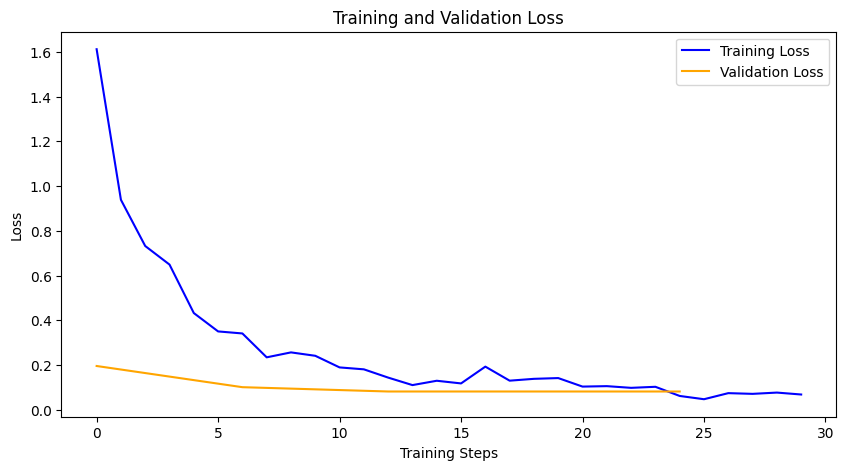

In [26]:
import matplotlib.pyplot as plt

# Assuming `train_loss` and `eval_loss` are already defined
train_loss = trainer.state.log_history

# Extract training and evaluation losses
train_losses = [log["loss"] for log in train_loss if "loss" in log]
eval_losses = [log["eval_loss"] for log in train_loss if "eval_loss" in log]


# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss", color="blue")

# Plot validation loss
# plot at the specific points where validation was evaluated
eval_steps = [i * len(train_losses) // len(eval_losses) for i in range(len(eval_losses))]
plt.plot(eval_steps, eval_losses, label="Validation Loss", color="orange")

# Labeling the plot
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


In [28]:
# Run predictions on the validation set
predictions, labels, _ = trainer.predict(valid_tokenized)
predictions = predictions.argmax(axis=2)

# Convert predictions and labels to their string labels
true_labels = [[label_list[l] for l in label if l != -100] for label in labels]
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
